In [1]:
%load_ext rpy2.ipython
from IPython.display import FileLink

In [3]:
%%R
workDir = '/home/chantal/Chazy/Chazy_SIP/data/'
figDir = '/home/chantal/Chazy/Chazy_SIP/data/figs/'

physeqDir = '/home/chantal/Chazy/data/phyloseq/'
physeqBulk = 'bulk-core-rare'

#physeqBulk = 'bulk-core' 

l2fcResFile = file.path(workDir, 'l2fc_sparse-maxRejH.txt')




## NOTEBOOK RUN WITH 0.25 SPARSITY FILTERED DATASET...

nprocs = 20

In [2]:
%%R
library(dplyr)
library(ggplot2)
#library(rwantshue)
library(grid); library(gridExtra)
library(magrittr)
library(phyloseq)

/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: 
Attaching package: ‘dplyr’


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:stats’:

    filter, lag


  res = super(Function, self).__call__(*new_args, **new_kwargs)
/opt/anaconda/lib/python2.7/site-packages/rpy2/robjects/functions.py:106: UserWarning: The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


  res = super(Function, self).__call__(*new_args, **new_kwargs)


In [4]:
%%R 

F = file.path(physeqDir, physeqBulk)
physeq.Bulk = readRDS(F)
physeq.Bulk.m = physeq.Bulk %>% sample_data
physeq.Bulk = prune_samples((physeq.Bulk.m$Land_Management != "PAS"),
                           physeq.Bulk)
physeq.Bulk.m = physeq.Bulk %>% sample_data


physeq.Bulk

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 19331 taxa and 175 samples ]
sample_data() Sample Data:       [ 175 samples by 25 sample variables ]
tax_table()   Taxonomy Table:    [ 19331 taxa by 8 taxonomic ranks ]
phy_tree()    Phylogenetic Tree: [ 19331 tips and 19330 internal nodes ]


In [5]:
%%R
mdf = psmelt(physeq.Bulk)

In [8]:
%%R
head(mdf)

            OTU          Sample Abundance     Full.sample Fraction PrimerF
3255245 OTU.912 Sept.NTH.1.2015      2081 Sept.NTH.1.2015       NA    515f
283958   OTU.12         N.NTH.4       717         N.NTH.4       NA    515f
283891   OTU.12         O.NTH.3       639         O.NTH.3       NA    515f
283933   OTU.12         N.NTH.2       634         N.NTH.2       NA    515f
43796   OTU.103    July15.PTH.2       619    July15.PTH.2       NA    515f
283880   OTU.12  Oct.NTH.3.2015       606  Oct.NTH.3.2015       NA    515f
        PrimerR Barcode Rev.index Fwd.index Treatment Day Replicate Pool
3255245    806r      22  acgctact  cgtgagtg      <NA>  NA         1    8
283958     806r     177  gtctatga  ctactata      <NA>  NA         4    5
283891     806r     158  cgagcgac  tcgacgag      <NA>  NA         3    5
283933     806r     175  gtctgcta  gatcgtgt      <NA>  NA         2    5
43796      806r     101  cgagagtt  acgtctcg      <NA>  NA         2    4
283880     806r      54  tagtctcc  cg

In [107]:
%%R
bulk.df = mdf %>%
    group_by(Sample_Date, Land_Management, Replicate) %>%
    mutate(relative.abundance = Abundance / sum(Abundance)) %>%
    group_by(OTU, Rank2, Rank3, Rank4, Sample_Date, Land_Management, Replicate) %>%
    summarize(`Relative Abundance` = mean(relative.abundance)) 

In [103]:
%%R
head(bulk.df)

Source: local data frame [6 x 3]
Groups: Sample_Date [2]

  Sample_Date Replicate Relative Abundance
       (fctr)     (int)              (dbl)
1    10/27/15         1        1.29326e-05
2    10/27/15         2        1.29326e-05
3    10/27/15         3        1.29326e-05
4    10/27/15         4        1.29326e-05
5    10/29/14         1        1.29326e-05
6    10/29/14         2        1.29326e-05


In [104]:
%%R
df.l2fc = read.table("data/l2fc_sparse-maxRejH.txt", sep = '\t', header = TRUE)

df.l2fc %<>% {
    tmp = filter(., padj <= 0.10) %>%
        group_by(OTU, Substrate, Land_Management) %>%
        summarize(min.p = min(padj)) %>%
        group_by(OTU, Land_Management) %>%
        summarize(S = sum(min.p <= 0.10)) %>%
        mutate(rspnse = ifelse(S > 1, "both", "one")) %>%
        select(OTU, rspnse)
        df.l2fc %>% left_join(tmp)

    }

In [105]:
%%R
FDR = 0.10

minP.df = df.l2fc %>%
    group_by(OTU, rspnse, Rank2, Land_Management) %>%
    summarize(minP = min(padj)) %>%
    filter(minP <= FDR) %>%
    group_by()

In [85]:
%%R
minP.df %>% group_by(Rank2, Land_Management) %>% summarise(num = n()) %>% ungroup() %>% arrange(-num) %>% as.data.frame()

                       Rank2 Land_Management num
1           __Proteobacteria             NTH 300
2           __Proteobacteria             PTH 176
3           __Actinobacteria             NTH  90
4           __Planctomycetes             NTH  79
5           __Actinobacteria             PTH  76
6           __Planctomycetes             PTH  60
7            __Bacteroidetes             NTH  56
8          __Verrucomicrobia             NTH  56
9              __Chloroflexi             PTH  49
10           __Bacteroidetes             PTH  40
11             __Chloroflexi             NTH  38
12         __Verrucomicrobia             PTH  35
13              __Firmicutes             PTH  31
14              __Firmicutes             NTH  21
15           __Cyanobacteria             NTH   9
16           __Fibrobacteres             NTH   9
17         __Armatimonadetes             PTH   7
18            __Spirochaetes             NTH   7
19           __Acidobacteria             PTH   6
20         __Armatim

TableGrob (8 x 1) "arrange": 8 grobs
  z     cells    name           grob
1 1 (1-1,1-1) arrange gtable[layout]
2 2 (2-2,1-1) arrange gtable[layout]
3 3 (3-3,1-1) arrange gtable[layout]
4 4 (4-4,1-1) arrange gtable[layout]
5 5 (5-5,1-1) arrange gtable[layout]
6 6 (6-6,1-1) arrange gtable[layout]
7 7 (7-7,1-1) arrange gtable[layout]
8 8 (8-8,1-1) arrange gtable[layout]


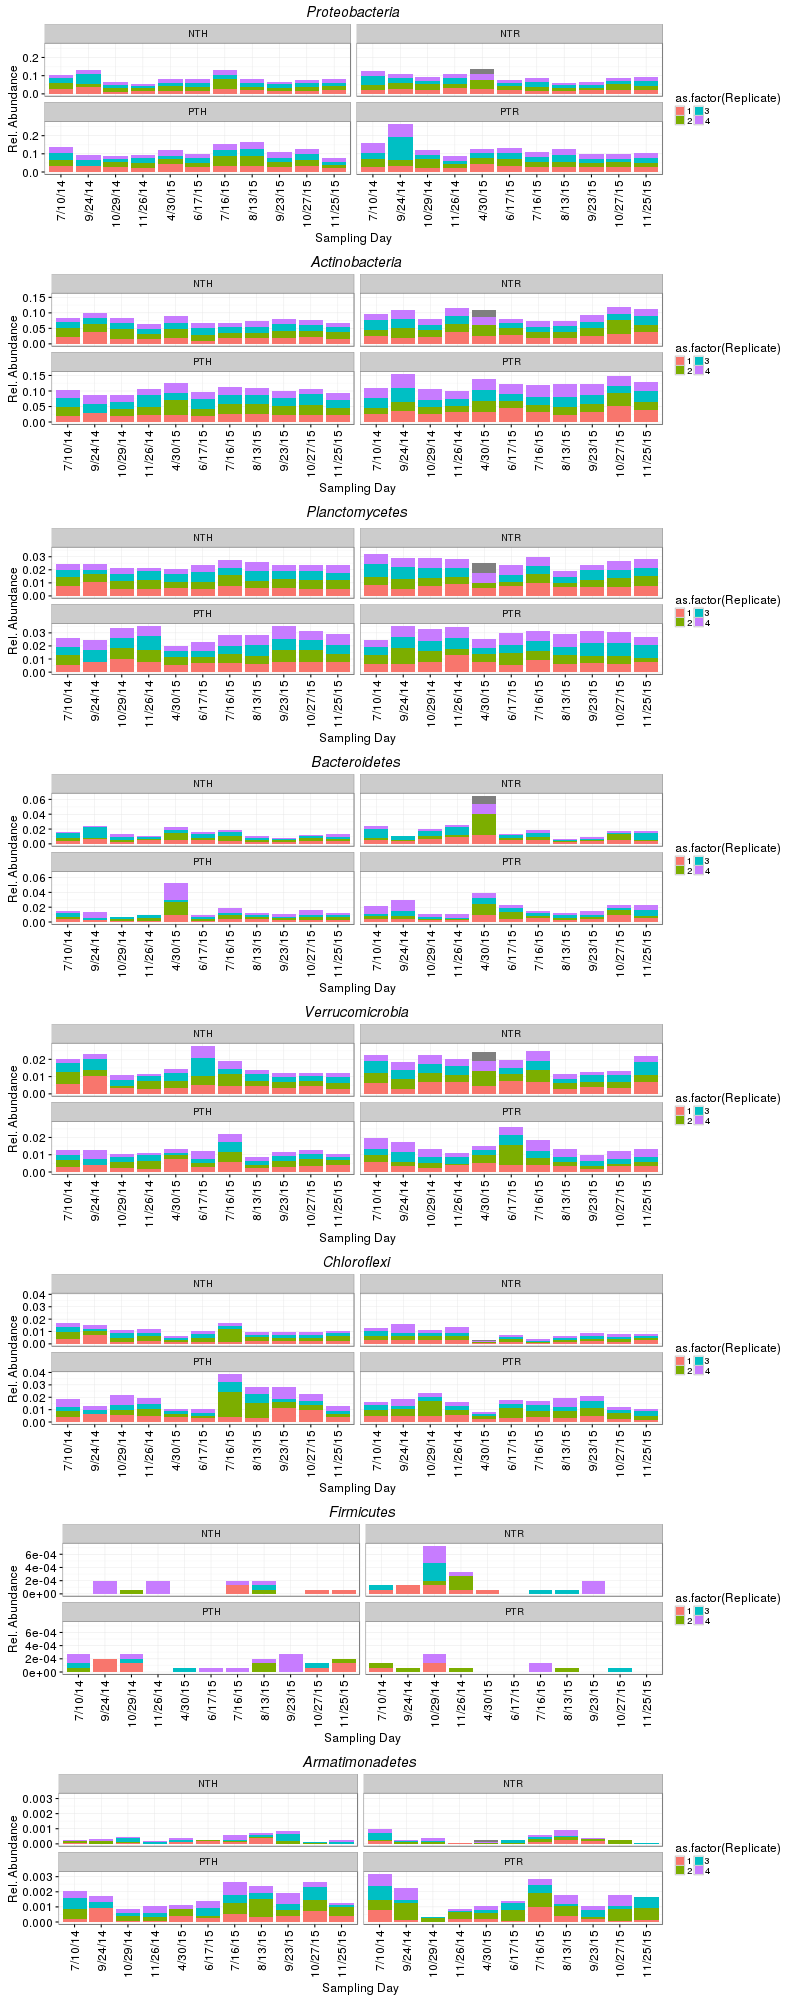

In [112]:
%%R -w 800 -h 2000

#scheme = iwanthue()

phyla = c("Proteobacteria", "Actinobacteria", "Planctomycetes", 
          "Bacteroidetes", "Verrucomicrobia", "Chloroflexi", "Firmicutes", "Armatimonadetes")
#t = "13CCPS"
bulk.df$Rank2 = gsub("__", "", bulk.df$Rank2)
minP.df$Rank2 = gsub("__", "", minP.df$Rank2)

bulk.df$Sample_Date = factor(bulk.df$Sample_Date, 
                                        levels = c('7/10/14', '9/24/14', '10/29/14', '11/26/14', 
                                                  '4/30/15', '6/17/15', '7/16/15', '8/13/15', 
                                                  '9/23/15', '10/27/15', '11/25/15'))

filt = minP.df %>% 
    filter(Rank2 %in% phyla)# %>%
    #arrange(Rank3, `Relative Abundance`)

d = filter(bulk.df, OTU %in% filt$OTU)#, 'Relative Abundance' > 0)


plot = function(r, d) {
    plot.d = d %>% filter(Rank2 == r) %>% group_by(Replicate)
    plot.d = plot.d %>% group_by(Replicate, Sample_Date, Land_Management) %>% summarize(RA = sum(`Relative Abundance`)) 
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

    p = ggplot(plot.d, aes(x = factor(Sample_Date), y = RA, fill = as.factor(Replicate), 
                           group = Replicate))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Sampling Day", y = "Rel. Abundance")

    #p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = guide_legend(ncol = 2))
    
    p = p + theme_bw()
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
    p = p + ggtitle(substitute(paste(italic(b), sep = ""), 
                               list(a = t, b = r)))
    p = p + facet_wrap(~Land_Management) #+ guides(fill=FALSE)# + scale_x_discrete(breaks=NULL)

    p = p +   theme(text = element_text(size=12),
        axis.title.y = element_text(vjust=1),
        axis.text.x = element_text(angle=90, vjust=0.5, hjust=1)) 
    p}
    
plots.13CCPS = lapply(phyla, plot, d = d)

p = do.call(grid.arrange, c(plots.13CCPS,list(ncol=1)))
p

In [80]:
%%R
ggsave(p, filename = 'data/figs/Responders_SeasonalAb.jpg', height = 20, width = 10)

In [90]:
%%R
head(minP.df)

Source: local data frame [6 x 5]

        OTU rspnse          Rank2 Land_Management         minP
     (fctr)  (chr)          (chr)          (fctr)        (dbl)
1     OTU.1    one Actinobacteria             NTH 5.829598e-04
2     OTU.1    one Actinobacteria             PTH 9.896447e-02
3    OTU.10    one  Bacteroidetes             NTH 2.411256e-07
4    OTU.10    one  Bacteroidetes             PTH 6.921662e-04
5 OTU.10051    one Proteobacteria             NTH 2.379633e-04
6  OTU.1008    one Proteobacteria             NTH 5.558541e-07


In [66]:
%%R
plot.d = d %>% filter(Rank2 == 'Proteobacteria')
    #colors = scheme$hex(length(unique(plot.d$OTU)), color_space = hcl_presets$intense)

    p = ggplot(plot.d, aes(x = factor(Sample_Date), y = `Relative Abundance`, fill = OTU))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Day", y = "Rel. Abundance")

    #p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = guide_legend(ncol = 2))
    
    p = p + theme_bw()
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
  
    p = p + facet_wrap(~Land_Management)

    p

RRuntimeError: Error: Faceting variables must have at least one value


In [15]:
%%R
pdf("../data/figs/abund_v_time_phyla.pdf", h = 15, w = 10)
do.call(grid.arrange, c(plots.13CCPS, list(ncol=1, nrow = 7)))
dev.off()


png 
  2 


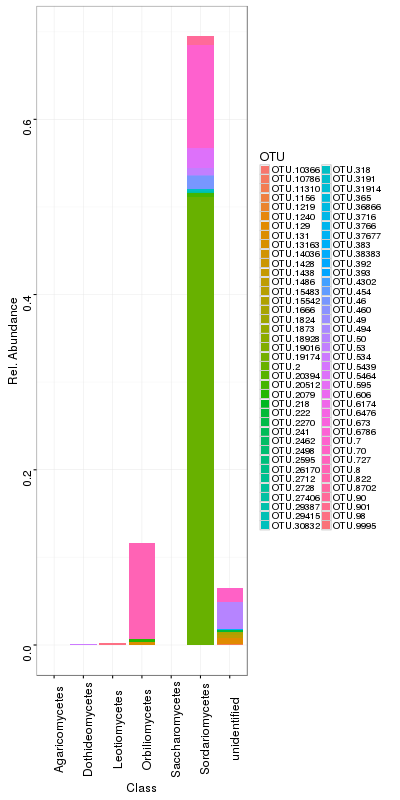

In [18]:
%%R -w 400 -h 800

#scheme = iwanthue()

phyla = c("Sordariomycetes", "Agaricomycetes", "Dothideomycetes", 
          "Leotiomycetes", "Orbiliomycetes", "Saccharomycetes", "unidentified")
#t = "13CCPS"
bulk.df$Rank3 = gsub("c__", "", bulk.df$Rank3)

filt = minP.df %>% 
    filter(Rank3 %in% phyla)# %>%
    #arrange(Rank3, `Relative Abundance`)

d = filter(bulk.df, OTU %in% filt$OTU)#, 'Relative Abundance' > 0)


    p = ggplot(d, aes(x = Rank3, y = `Relative Abundance`, fill = OTU))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Class", y = "Rel. Abundance")

    #p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = guide_legend(ncol = 2))
    
    p = p + theme_bw()
    
    p = p + theme(axis.text = element_text(size = 12, angle = 90),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
   # p = p + ggtitle(substitute(paste(italic(b), sep = ""), 
    #                           list(a = t, b = r)))

    p

In [22]:
%%R
d %>% group_by(Rank3) %>% summarise(totalRA = sum(`Relative Abundance`))

Source: local data frame [7 x 2]

            Rank3      totalRA
            (chr)        (dbl)
1  Agaricomycetes 0.0004120879
2 Dothideomycetes 0.0009939377
3   Leotiomycetes 0.0028687406
4  Orbiliomycetes 0.1165277494
5 Saccharomycetes 0.0001696578
6 Sordariomycetes 0.6946449189
7    unidentified 0.0654093263


In [17]:
FileLink("figs/abund_v_time_phyla.pdf")


/home/chantal/FungalSIP/BulkCommunity/figs/abund_v_time_phyla.pdf

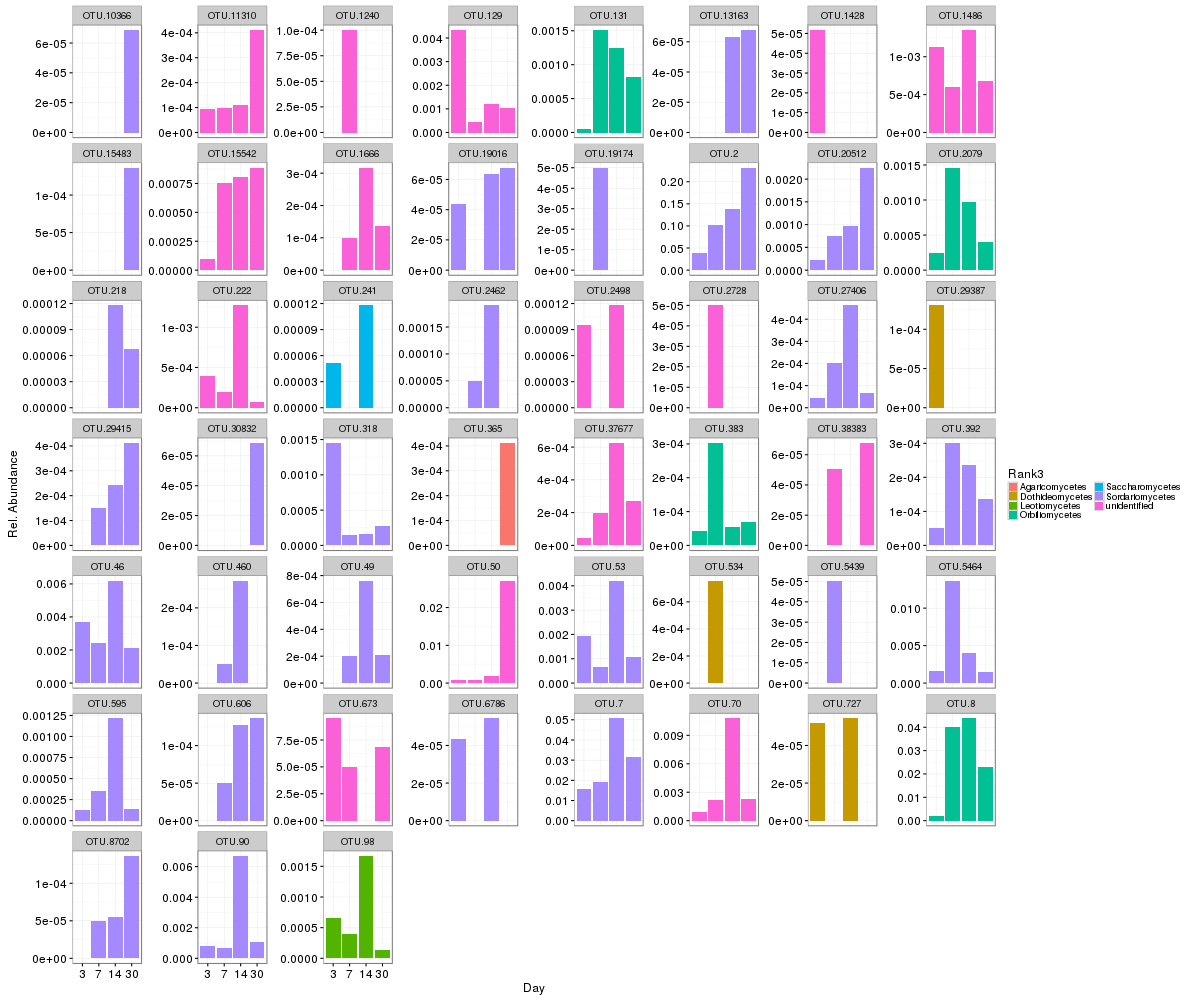

In [33]:
 %%R -w 1200 -h 1000
    
    d2= filter(d, `Relative Abundance` > 0)
    
    p = ggplot(d2, aes(x = factor(Day), y = `Relative Abundance`, fill = Rank3))

    p = p + geom_bar(stat = "identity")
    
    p = p + labs(x = "Day", y = "Rel. Abundance")

    #p = p + scale_fill_manual(values = colors)
    
    p = p + guides(fill = guide_legend(ncol = 2))
    
    p = p + theme_bw()
    
    p = p + theme(axis.text = element_text(size = 12),
                  legend.key.height = unit(0.65, "lines"),
                  legend.key.width = unit(0.65, "lines"),
                  legend.text = element_text(size = 9))
    
  #  p = p + ggtitle(substitute(paste(italic(b), sep = ""), 
   #                            list(a = t, b = r)))
    
    p = p + facet_wrap(~OTU, scales = "free_y")

    p

In [18]:
%%R 
head(d)

Source: local data frame [6 x 6]
Groups: OTU, Rank2, Rank3, Rank4 [2]

        OTU         Rank2           Rank3          Rank4   Day
      (chr)        (fctr)           (chr)         (fctr) (int)
1 OTU.10366 p__Ascomycota Sordariomycetes o__Sordariales     3
2 OTU.10366 p__Ascomycota Sordariomycetes o__Sordariales     7
3 OTU.10366 p__Ascomycota Sordariomycetes o__Sordariales    14
4 OTU.10366 p__Ascomycota Sordariomycetes o__Sordariales    30
5 OTU.10786 p__Ascomycota Sordariomycetes o__Sordariales     3
6 OTU.10786 p__Ascomycota Sordariomycetes o__Sordariales     7
Variables not shown: Relative Abundance (dbl)
